# Imports

In [116]:
import os
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import timeit

import pandas as pd

import tensorflow as tf
import keras
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input, AveragePooling2D
from sklearn.model_selection import train_test_split

# Déclaration variables globales

In [2]:
races = os.listdir('./Images_half')

nb_races = len(races)
size = 150

src_path_train = "./Images_all"
src_path_test = "./Images_all"

# Création data frames avec les images test et train

In [3]:
df_dogs_train = pd.DataFrame(columns=['Chien_img','Race'])
df_dogs_test = pd.DataFrame(columns=['Chien_img','Race'])

In [4]:
for i in races :
    tmp_list = os.listdir('./Images_half/' + i)
    all_chiens = pd.DataFrame({'Race' : str(i), 'Chien' : tmp_list})
    
    X = np.array(all_chiens['Chien'])
    y = np.array(all_chiens['Race'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    for i in range( len(X_train) ) :
        race = y_train[i].split("-")
        df_dogs_train = df_dogs_train.append({'Chien_img' : y_train[i] + '/' + X_train[i], 'Race' : race[1]} , ignore_index=True)
        
    for i in range( len(X_test) ) :
        race = y_test[i].split("-")
        df_dogs_test = df_dogs_test.append({'Chien_img' : y_test[i] + '/' + X_test[i], 'Race' : race[1]} , ignore_index=True)

# Labelisation des races

In [5]:
label_name = df_dogs_test['Race'].unique()

In [6]:
index = 0
df_lablels = pd.DataFrame(columns=['Race','Index'])

for i in label_name :
    df_lablels = df_lablels.append({'Race' : i , 'Index' : index} , ignore_index=True)
    index+=1

In [7]:
df_lablels

Race Index
0             Chihuahua     0
1      Japanese_spaniel     1
2           Maltese_dog     2
3              Pekinese     3
4                  Shih     4
5      Blenheim_spaniel     5
6              papillon     6
7           toy_terrier     7
8   Rhodesian_ridgeback     8
9          Afghan_hound     9
10               basset    10
11               beagle    11
12           bloodhound    12
13             bluetick    13
14                black    14
15         Walker_hound    15
16     English_foxhound    16
17              redbone    17
18               borzoi    18
19      Irish_wolfhound    19

In [8]:
df_dogs_train

Chien_img             Race
0           n02085620-Chihuahua/n02085620_1558.jpg        Chihuahua
1           n02085620-Chihuahua/n02085620_9414.jpg        Chihuahua
2           n02085620-Chihuahua/n02085620_6931.jpg        Chihuahua
3           n02085620-Chihuahua/n02085620_8491.jpg        Chihuahua
4           n02085620-Chihuahua/n02085620_5771.jpg        Chihuahua
...                                            ...              ...
2528  n02090721-Irish_wolfhound/n02090721_6437.jpg  Irish_wolfhound
2529  n02090721-Irish_wolfhound/n02090721_4362.jpg  Irish_wolfhound
2530  n02090721-Irish_wolfhound/n02090721_1706.jpg  Irish_wolfhound
2531  n02090721-Irish_wolfhound/n02090721_1644.jpg  Irish_wolfhound
2532  n02090721-Irish_wolfhound/n02090721_1268.jpg  Irish_wolfhound

[2533 rows x 2 columns]

In [9]:
df_dogs_test

Chien_img             Race
0           n02085620-Chihuahua/n02085620_3409.jpg        Chihuahua
1           n02085620-Chihuahua/n02085620_8585.jpg        Chihuahua
2           n02085620-Chihuahua/n02085620_3975.jpg        Chihuahua
3           n02085620-Chihuahua/n02085620_1916.jpg        Chihuahua
4           n02085620-Chihuahua/n02085620_1569.jpg        Chihuahua
...                                            ...              ...
1095   n02090721-Irish_wolfhound/n02090721_868.jpg  Irish_wolfhound
1096  n02090721-Irish_wolfhound/n02090721_1540.jpg  Irish_wolfhound
1097   n02090721-Irish_wolfhound/n02090721_363.jpg  Irish_wolfhound
1098  n02090721-Irish_wolfhound/n02090721_2651.jpg  Irish_wolfhound
1099  n02090721-Irish_wolfhound/n02090721_2536.jpg  Irish_wolfhound

[1100 rows x 2 columns]

# Preprocessing

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=40,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split=0.3
)

test_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
)

# Initialisation de nos images Train, Validation et Test

In [11]:
batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_dogs_train,
    directory=src_path_train,
    x_col="Chien_img",
    y_col="Race",
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# A tester avec son propredatagen + création propre DF
# !!! ne pas data augmenter les images de Validation !!!
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_dogs_train,
    directory=src_path_train,
    x_col="Chien_img",
    y_col="Race",
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_dogs_test,
    directory=src_path_test,
    x_col="Chien_img",
    target_size=(size, size),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 1774 validated image filenames belonging to 20 classes.
Found 759 validated image filenames belonging to 20 classes.
Found 1100 validated image filenames.


# Initialisation des CNN custom

## Model complexe :

- Races prises en compte = 20 
- Temps d'exécution = 27 min 45 sec
- Accuracy = 0.27
- Loss = 2.2

### Initialisation du modèle :

In [12]:
def prepare_model_complexe():
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(size, size, 3)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(nb_races, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
    
    return model

In [13]:
model_complexe = prepare_model_complexe()
model_complexe.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

### Fit du modèle :

In [14]:
%%time
history_1 = model_complexe.fit(train_generator, validation_data = train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
validation_steps = valid_generator.n//valid_generator.batch_size,epochs=20)

Epoch 1/20
88/88 [==============================] - 84s 942ms/step - loss: 4.1148 - accuracy: 0.0715 - val_loss: 3.4997 - val_accuracy: 0.0473
Epoch 2/20
88/88 [==============================] - 83s 945ms/step - loss: 3.5340 - accuracy: 0.0925 - val_loss: 3.3859 - val_accuracy: 0.0676
Epoch 3/20
88/88 [==============================] - 82s 926ms/step - loss: 3.3332 - accuracy: 0.0949 - val_loss: 2.8055 - val_accuracy: 0.1378
Epoch 4/20
88/88 [==============================] - 82s 928ms/step - loss: 3.2589 - accuracy: 0.1058 - val_loss: 2.7224 - val_accuracy: 0.1446
Epoch 5/20
88/88 [==============================] - 83s 945ms/step - loss: 3.0060 - accuracy: 0.1315 - val_loss: 2.6910 - val_accuracy: 0.1419
Epoch 6/20
88/88 [==============================] - 82s 940ms/step - loss: 2.9667 - accuracy: 0.1249 - val_loss: 2.8038 - val_accuracy: 0.1054
Epoch 7/20
88/88 [==============================] - 82s 934ms/step - loss: 2.7967 - accuracy: 0.1380 - val_loss: 2.5384 - val_accuracy: 0.1865

### Evaluation du modèle :

In [15]:
loss, accuracy = model_complexe.evaluate(train_generator)
print(loss,accuracy)

89/89 [==============================] - 14s 153ms/step - loss: 2.2040 - accuracy: 0.2723
2.204019546508789 0.27226606011390686


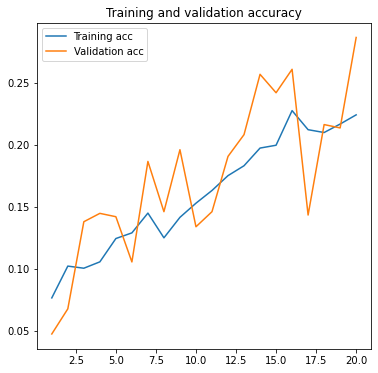

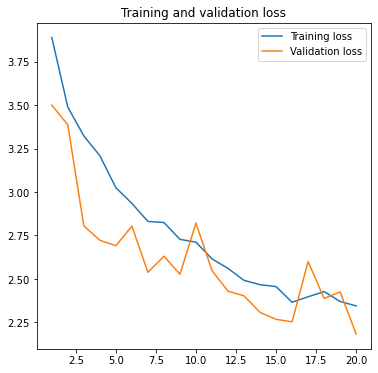

In [16]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()

plt.show()

###################################################################################################

## Model made by Me :

- Races prises en compte = 120 
- Temps d'exécution = 5 min 45 sec
- Accuracy = 0.08
- Loss = 3.93

/////////////////////////////

- Races prises en compte = 20 
- Temps d'exécution = 5 min 49 sec
- Accuracy = 0.39
- Loss = 1.82

### Evaluation du modèle :

In [19]:
def prepare_model_selfmade():
    model = Sequential()
    
    model.add(Conv2D(16,3,activation='relu',input_shape=(size, size, 3)))  # activation (valeurs négatives => 1)
    model.add(MaxPooling2D(2)) # pooling (réduction d'image tout en gardant les caractéristiques )
    
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(nb_races, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [20]:
model_seld_made = prepare_model_selfmade()
model_seld_made.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

### Fit du modèle :

In [21]:
%%time
history_2 = model_seld_made.fit(train_generator,validation_data = train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
validation_steps = valid_generator.n//valid_generator.batch_size, epochs=20)

Epoch 1/20
88/88 [==============================] - 18s 198ms/step - loss: 2.9336 - accuracy: 0.0753 - val_loss: 2.5841 - val_accuracy: 0.1351
Epoch 2/20
88/88 [==============================] - 17s 195ms/step - loss: 2.6265 - accuracy: 0.1391 - val_loss: 2.5017 - val_accuracy: 0.1770
Epoch 3/20
88/88 [==============================] - 17s 195ms/step - loss: 2.5213 - accuracy: 0.1513 - val_loss: 2.4355 - val_accuracy: 0.2054
Epoch 4/20
88/88 [==============================] - 17s 195ms/step - loss: 2.4670 - accuracy: 0.1845 - val_loss: 2.4057 - val_accuracy: 0.1932
Epoch 5/20
88/88 [==============================] - 18s 199ms/step - loss: 2.4085 - accuracy: 0.2051 - val_loss: 2.3950 - val_accuracy: 0.1959
Epoch 6/20
88/88 [==============================] - 17s 196ms/step - loss: 2.3588 - accuracy: 0.2032 - val_loss: 2.3635 - val_accuracy: 0.2297
Epoch 7/20
88/88 [==============================] - 18s 204ms/step - loss: 2.3333 - accuracy: 0.2408 - val_loss: 2.2715 - val_accuracy: 0.2392

### Evaluation du modèle :

In [23]:
loss, accuracy = model_seld_made.evaluate(train_generator)

print(loss,accuracy)

89/89 [==============================] - 10s 108ms/step - loss: 1.8225 - accuracy: 0.3935
1.8224903345108032 0.39346110820770264


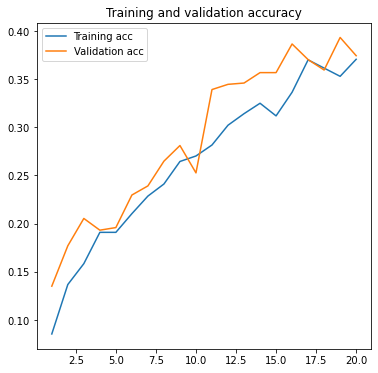

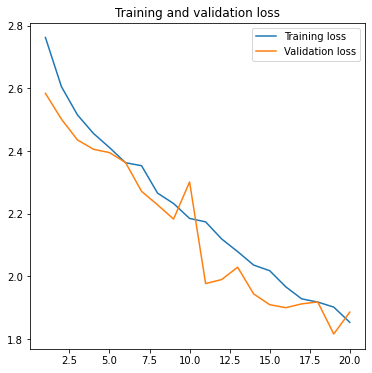

In [24]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()

plt.show()

# Predictions avec le modèle fait maison (pas foufou)

In [26]:
predict=model_seld_made.predict_generator(test_generator, steps = len(test_generator.filenames))
y_classes = predict.argmax(axis=-1)

C:\Users\Belkacem Amrouche\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


### Méthode d'affichage de toutes les prédictions

In [91]:
for i in range(len(df_dogs_test['Chien_img'])) :
    
    print('Probabilités de prédiction : ')
    print (predict[i])
    
    print('\n')
    
    #print('Prédiction : ' + str(y_classes[i]))
    print('Prédiction : ' + df_lablels['Race'][y_classes[i]])
    print('Réalité : ' + str(df_dogs_test['Race'][i]))
    
    print('\n')
    print('=================================================================')
    print('\n')

Probabilités de prédiction : 
[1.53915500e-02 5.93360653e-03 3.97577224e-07 1.99830532e-03
 2.88836635e-03 4.05972969e-06 4.34064668e-06 2.32848924e-06
 7.84479603e-02 1.28560498e-06 8.65041465e-03 1.05699286e-01
 2.87481695e-01 1.00541804e-02 5.86173870e-02 2.30166968e-02
 1.52530940e-02 1.30554542e-01 6.59578890e-02 1.90042570e-01]


Prédiction : bloodhound
Réalité : Chihuahua




Probabilités de prédiction : 
[2.1397393e-02 7.1789315e-03 1.1852669e-06 4.0044986e-02 2.0989483e-02
 3.4578193e-06 1.9803310e-06 2.2786778e-06 7.4944839e-02 2.2154156e-06
 4.0037435e-02 6.3591942e-02 2.1052478e-01 7.2221691e-03 1.1334347e-01
 7.0464566e-02 7.3428843e-03 3.6218170e-02 5.8853466e-02 2.2783446e-01]


Prédiction : Irish_wolfhound
Réalité : Chihuahua




Probabilités de prédiction : 
[1.06748924e-01 3.27134132e-03 1.05141344e-05 9.28079430e-03
 4.30993736e-02 1.89307666e-05 1.66535319e-05 2.50156772e-05
 1.03390245e-02 1.21732983e-05 5.43550700e-02 6.75036758e-02
 7.63424486e-02 5.74916340e-02 

 0.0837326  0.05954982]


Prédiction : Rhodesian_ridgeback
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[4.60652576e-04 6.92866743e-02 2.33736497e-08 6.38083667e-02
 9.74201685e-05 8.38220799e-08 3.12286978e-08 5.31187112e-08
 1.66293082e-03 2.67450151e-08 1.15459464e-01 2.49257982e-01
 4.75092977e-02 1.95472850e-04 1.37541909e-03 9.18937474e-03
 2.76150717e-03 1.66223213e-01 3.54540930e-03 2.69166529e-01]


Prédiction : Irish_wolfhound
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[1.3591602e-02 3.8471092e-02 7.8127749e-07 2.6621538e-01 3.8117811e-03
 2.1181336e-06 1.5905217e-06 1.4219988e-06 1.9885488e-01 1.2846909e-06
 1.0658149e-01 8.2889296e-02 9.1673620e-02 2.3009377e-03 5.3397048e-02
 4.0033641e-03 2.7078234e-03 2.3103636e-02 8.3538756e-02 2.8851995e-02]


Prédiction : Pekinese
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[6.2435766e-04 3.1459592e-02 3.4335983e-09 7.4899293e-02 8.2707564e-05
 9.5550075e-09 3.0957736e-09 4.5599844e-0



Prédiction : Chihuahua
Réalité : Afghan_hound




Probabilités de prédiction : 
[1.2104825e-01 7.2461879e-04 4.3882267e-08 8.3276825e-03 5.5252731e-01
 1.3139187e-07 4.8361454e-08 1.2614329e-07 6.8009071e-02 2.7486146e-07
 9.3281856e-03 6.7356071e-03 3.3657663e-02 3.7985328e-03 2.7184326e-02
 4.0567782e-02 4.8164878e-02 9.5501943e-03 5.9218789e-03 6.4453512e-02]


Prédiction : Shih
Réalité : Afghan_hound




Probabilités de prédiction : 
[7.4358076e-02 1.9944531e-03 7.7054437e-06 1.3175193e-02 7.7307984e-02
 2.1000631e-05 1.8465353e-05 1.6035054e-05 5.0992328e-03 2.2336963e-05
 2.0281568e-02 4.2466454e-02 3.8322456e-02 3.6846459e-02 5.9315901e-02
 2.6135263e-01 7.5910613e-02 1.6705415e-01 5.5983760e-03 1.2083097e-01]


Prédiction : Walker_hound
Réalité : Afghan_hound




Probabilités de prédiction : 
[3.1602877e-01 5.8284946e-05 9.5419438e-08 1.4314201e-03 2.5358057e-01
 3.4692616e-07 1.1590135e-07 2.3722021e-07 1.2490748e-03 1.3567865e-07
 1.5141793e-02 1.5687017e-03 6.5181730e-03 1




Probabilités de prédiction : 
[3.0436860e-03 8.7949721e-04 1.6529825e-08 8.1036896e-02 1.9824104e-03
 3.7791668e-08 1.5245540e-08 7.5578939e-09 2.1174646e-05 2.7950545e-08
 2.1471603e-01 8.6918743e-03 9.2973411e-03 6.4638432e-04 2.6864134e-04
 1.6262081e-01 5.0527643e-02 2.0804323e-01 1.4125684e-04 2.5808296e-01]


Prédiction : Irish_wolfhound
Réalité : Walker_hound




Probabilités de prédiction : 
[2.63386959e-04 4.66627302e-03 4.82422380e-10 2.44502146e-02
 1.02110185e-04 3.43503737e-09 1.09762965e-09 1.14063825e-09
 2.71102308e-05 2.22177721e-09 1.35808855e-01 4.78972606e-02
 2.70388145e-02 1.12480438e-05 3.90836736e-04 1.61358193e-02
 1.50379930e-02 4.29911256e-01 1.92566193e-04 2.98066288e-01]


Prédiction : redbone
Réalité : Walker_hound




Probabilités de prédiction : 
[1.62031595e-02 2.55978387e-02 7.44305510e-07 2.29703590e-01
 2.00545639e-02 4.06114168e-06 2.54681527e-06 2.31222839e-06
 1.53510511e-01 1.66541645e-06 1.15623005e-01 6.05350919e-02
 9.73545387e-02 3.5991822

### Méthode d'affichage de la prédiction d'une image en particulier

In [57]:
def predict_img(index_image) :
    
    print('Probabilités de prédiction : ')
    print (predict[index_image])
    
    print('\n')
    #print('Prédiction : ' + str(y_classes[index_image]))
    print('Prédiction : ' + df_lablels['Race'][y_classes[index_image]])
    print('Réalité : ' + str(df_dogs_test['Race'][index_image]))
    
    filename = '././Images_all/' + df_dogs_test['Chien_img'][index_image]
    image = imread(filename)
    plt.imshow(image)
    plt.title("Image : " + filename.split("/")[len(filename.split("/"))-1])
    
    print('\n')
    print('=================================================================')
    print('\n')

Probabilités de prédiction : 
[1.53915500e-02 5.93360653e-03 3.97577224e-07 1.99830532e-03
 2.88836635e-03 4.05972969e-06 4.34064668e-06 2.32848924e-06
 7.84479603e-02 1.28560498e-06 8.65041465e-03 1.05699286e-01
 2.87481695e-01 1.00541804e-02 5.86173870e-02 2.30166968e-02
 1.52530940e-02 1.30554542e-01 6.59578890e-02 1.90042570e-01]


Prédiction : bloodhound
Réalité : Chihuahua






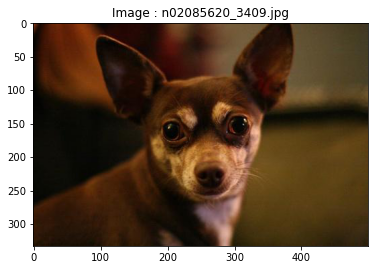

In [58]:
predict_img(0)

Probabilités de prédiction : 
[3.1273341e-01 1.2028559e-02 4.8172991e-05 7.9062711e-03 1.5237327e-01
 4.6842815e-05 4.9269031e-05 6.1282037e-05 6.6779539e-02 7.8461097e-05
 2.2735680e-02 2.9876446e-02 1.8288072e-02 3.3504345e-02 9.2956446e-02
 1.4313931e-02 1.6026996e-01 2.5245519e-02 2.1695681e-02 2.9008795e-02]


Prédiction : Chihuahua
Réalité : Chihuahua






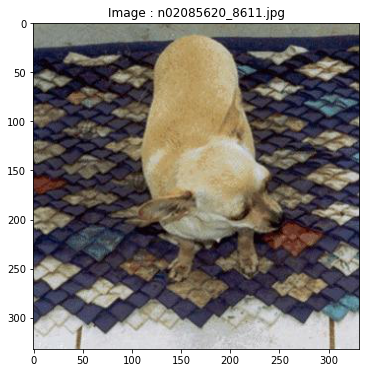

In [92]:
predict_img(7)

# =================================================

# Transfert learning

- Races prises en compte = 20 
- Temps d'exécution = 6 min 31 sec
- Accuracy = 0.76
- Loss = 0.83

## Création du modèle

In [88]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import applications
from keras.layers import GlobalAveragePooling2D

InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (size, size, 3))

In [90]:
model_inception = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False

model_inception.add(InceptionV3)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Dropout(0.25))

model_inception.add(Dense(nb_races, activation='softmax'))

model_inception.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                40980     
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


## Entrainement du modèle

In [100]:
model_inception.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [102]:
history_3 = model_inception.fit(train_generator,validation_data = train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
validation_steps = valid_generator.n//valid_generator.batch_size, epochs=20)

Epoch 1/20
88/88 [==============================] - 21s 233ms/step - loss: 1.7309 - accuracy: 0.5599 - val_loss: 1.2134 - val_accuracy: 0.6568
Epoch 2/20
88/88 [==============================] - 19s 220ms/step - loss: 1.5379 - accuracy: 0.6055 - val_loss: 1.1284 - val_accuracy: 0.6757
Epoch 3/20
88/88 [==============================] - 19s 221ms/step - loss: 1.4382 - accuracy: 0.6311 - val_loss: 1.4272 - val_accuracy: 0.6203
Epoch 4/20
88/88 [==============================] - 20s 223ms/step - loss: 1.4360 - accuracy: 0.6317 - val_loss: 1.1417 - val_accuracy: 0.6892
Epoch 5/20
88/88 [==============================] - 20s 222ms/step - loss: 1.3887 - accuracy: 0.6511 - val_loss: 1.3505 - val_accuracy: 0.6284
Epoch 6/20
88/88 [==============================] - 20s 224ms/step - loss: 1.3225 - accuracy: 0.6710 - val_loss: 1.0571 - val_accuracy: 0.7041
Epoch 7/20
88/88 [==============================] - 20s 224ms/step - loss: 1.3223 - accuracy: 0.6739 - val_loss: 1.2633 - val_accuracy: 0.6743

## Evaluation du modèle

In [104]:
loss, accuracy = model_inception.evaluate(train_generator)
print(loss,accuracy)

89/89 [==============================] - 14s 155ms/step - loss: 0.8322 - accuracy: 0.7599
0.8321742415428162 0.7598646879196167


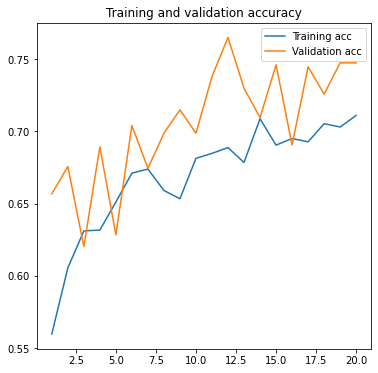

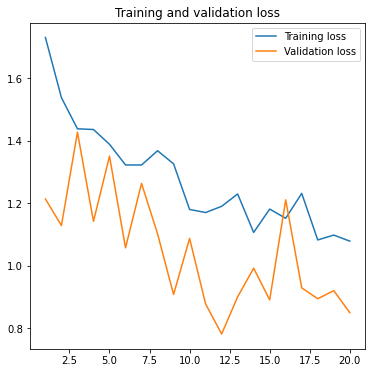

In [105]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()

plt.show()

# Prédictions avec le Transfert Learning

## Calcul des prédictions

In [106]:
predict_tl = model_inception.predict_generator(test_generator, steps = len(test_generator.filenames))
y_classes = predict_tl.argmax(axis=-1)

### Méthode d'affichage de toutes les prédictions

In [107]:
for i in range(len(df_dogs_test['Chien_img'])) :
    
    print('Probabilités de prédiction : ')
    print (predict_tl[i])
    
    print('\n')
    
    #print('Prédiction : ' + str(y_classes[i]))
    print('Prédiction : ' + df_lablels['Race'][y_classes[i]])
    print('Réalité : ' + str(df_dogs_test['Race'][i]))
    
    print('\n')
    print('=================================================================')
    print('\n')

Probabilités de prédiction : 
[1.2034619e-11 1.6795941e-10 9.2105880e-17 2.8788932e-06 6.9124275e-09
 1.4928018e-18 2.4072551e-19 3.2221938e-21 2.6044768e-08 5.4655537e-16
 1.0777399e-07 2.4232321e-07 2.8558750e-07 2.4486637e-12 1.0993403e-07
 3.1610330e-07 2.0835018e-10 1.0494741e-07 2.7755295e-05 9.9996817e-01]


Prédiction : Irish_wolfhound
Réalité : Chihuahua




Probabilités de prédiction : 
[1.5647450e-11 3.5347055e-11 4.4845440e-18 1.9957029e-06 8.6052045e-09
 1.0958199e-18 5.4747802e-20 5.1815343e-22 3.4279560e-10 2.8777891e-17
 4.9445351e-08 2.2915589e-08 2.7638616e-09 4.3300932e-11 4.1838824e-11
 1.6133651e-08 7.1586834e-11 9.0059541e-13 4.4607935e-07 9.9999750e-01]


Prédiction : Irish_wolfhound
Réalité : Chihuahua




Probabilités de prédiction : 
[1.04634901e-15 1.05340575e-15 6.62512083e-23 7.16437069e-14
 1.29406885e-11 6.07850312e-25 5.36127066e-26 3.62956713e-27
 5.57998309e-13 5.60681992e-22 2.35156924e-12 1.80578209e-11
 3.15498495e-13 1.82243803e-12 8.78745698e-13 2

 3.2864894e-10 5.3682198e-11 5.9015605e-08 2.6039091e-08 9.1617963e-11]


Prédiction : Japanese_spaniel
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[1.5279255e-09 9.9999964e-01 4.1099844e-19 7.5998496e-09 8.1074676e-13
 1.6738377e-19 5.7027072e-20 4.1005640e-23 1.1748078e-10 1.2094967e-15
 3.6720234e-11 1.0609461e-09 3.3611541e-10 1.3094370e-12 8.8372504e-11
 6.4175093e-10 1.1046201e-09 3.1812345e-07 4.6608006e-09 4.7637007e-12]


Prédiction : Japanese_spaniel
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[2.2783254e-11 1.0000000e+00 5.4497301e-19 5.5282667e-09 2.1081122e-14
 1.8759897e-20 3.4269272e-20 1.8657467e-22 2.1872309e-12 1.6672907e-15
 2.4711184e-11 1.7966595e-09 3.4804198e-10 6.8966647e-15 2.7772418e-10
 9.7543501e-12 2.0561344e-10 2.5514710e-08 1.5795104e-08 9.5504847e-11]


Prédiction : Japanese_spaniel
Réalité : Blenheim_spaniel




Probabilités de prédiction : 
[4.3828205e-12 9.9603611e-01 2.9342599e-19 7.3561904e-07 1.4044292e-12
 1.14124



Prédiction : beagle
Réalité : basset




Probabilités de prédiction : 
[8.5547117e-06 3.6647643e-06 1.2253359e-18 1.8160023e-04 2.0912246e-10
 3.7861378e-19 2.0172361e-16 2.8095723e-21 1.6379379e-07 1.6523111e-14
 2.8859906e-05 9.9462056e-01 1.1353415e-03 7.5018255e-11 3.8792277e-03
 1.0136008e-05 1.5397696e-08 6.2160476e-13 1.3209079e-04 3.4177492e-09]


Prédiction : beagle
Réalité : basset




Probabilités de prédiction : 
[3.2838673e-07 3.9040273e-09 9.7894783e-14 7.2952986e-05 2.1045658e-10
 2.7562158e-16 1.4551378e-13 6.2393903e-17 2.0551013e-07 3.8740061e-10
 5.1585806e-04 9.9654645e-01 2.6854288e-03 3.4242710e-08 1.4251239e-04
 3.5081623e-05 1.3895270e-10 6.3080431e-12 1.1634462e-06 1.8288084e-08]


Prédiction : beagle
Réalité : basset




Probabilités de prédiction : 
[6.45908549e-10 1.62776910e-11 4.03072275e-17 3.75377596e-08
 1.13470316e-10 5.18048577e-18 2.03248385e-14 5.04015209e-19
 1.33910050e-09 3.09999693e-13 6.81402753e-06 9.96374071e-01
 1.50507242e-06 1.54324800e-




Probabilités de prédiction : 
[3.9193448e-08 3.1192018e-11 8.2530299e-15 7.7657579e-03 2.4667133e-09
 4.0226620e-17 3.4607327e-14 4.3889169e-18 7.6760589e-09 5.3025823e-11
 8.8159180e-01 6.4280024e-03 1.0412867e-01 1.3729392e-07 1.1756512e-06
 8.3446888e-05 1.7944290e-10 6.0622310e-12 8.0046803e-08 9.0606051e-07]


Prédiction : basset
Réalité : English_foxhound




Probabilités de prédiction : 
[6.3973354e-10 6.8651207e-06 4.4777251e-19 9.1476403e-02 8.5418949e-05
 7.5401087e-20 3.6119681e-18 4.9334793e-23 4.9880223e-04 1.3101285e-14
 1.2239218e-01 1.0776364e-03 7.3872644e-01 5.9283902e-08 4.3466557e-02
 1.9857462e-03 1.2464861e-04 7.1478595e-10 1.3751759e-04 2.1662250e-05]


Prédiction : bloodhound
Réalité : English_foxhound




Probabilités de prédiction : 
[1.44203955e-08 1.01907780e-08 7.54285804e-16 7.37670541e-01
 5.64878248e-11 5.17020229e-16 2.39695056e-15 1.22630133e-19
 6.53244641e-08 1.13452442e-11 1.84331834e-01 4.34212743e-05
 7.77880624e-02 1.41460310e-09 2.80148379e-0

In [ ]:
# Matrice confusion par race

### Méthode d'affichage de la prédiction d'une image en particulier

In [108]:
def predict_img_tl(index_image) :
    
    print('Probabilités de prédiction : ')
    print (predict_tl[index_image])
    
    print('\n')
    #print('Prédiction : ' + str(y_classes[index_image]))
    print('Prédiction : ' + df_lablels['Race'][y_classes[index_image]])
    print('Réalité : ' + str(df_dogs_test['Race'][index_image]))
    
    filename = '././Images_all/' + df_dogs_test['Chien_img'][index_image]
    image = imread(filename)
    plt.imshow(image)
    plt.title("Image : " + filename.split("/")[len(filename.split("/"))-1])
    
    print('\n')
    print('=================================================================')
    print('\n')

Probabilités de prédiction : 
[1.18099593e-01 1.71772102e-04 3.28626264e-08 4.25590930e-04
 1.34028587e-02 5.76853871e-08 3.34710535e-08 6.60695534e-08
 8.75090016e-04 5.75032573e-08 8.19908455e-03 5.57856262e-03
 1.22013185e-02 2.78470591e-02 1.45214831e-03 2.95475014e-02
 1.20483115e-01 4.43657011e-01 2.66066520e-04 2.17793018e-01]


Prédiction : redbone
Réalité : Japanese_spaniel






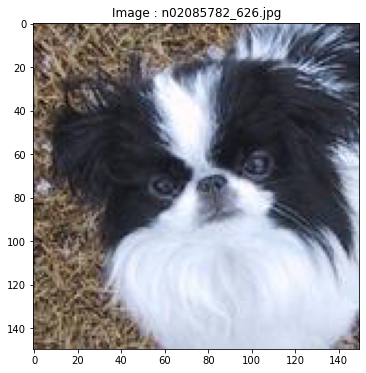

In [111]:
predict_img(59)

Probabilités de prédiction : 
[1.77780822e-01 1.26810872e-03 7.67492949e-08 8.51760991e-03
 3.31968486e-01 1.98994513e-07 1.06854209e-07 4.10338941e-07
 2.39450438e-03 1.35265608e-07 2.87401378e-02 1.01075117e-02
 1.64265018e-02 3.91460303e-03 1.03713246e-03 5.09198718e-02
 1.19448714e-01 1.58384629e-02 4.32063098e-04 2.31204599e-01]


Prédiction : bloodhound
Réalité : beagle






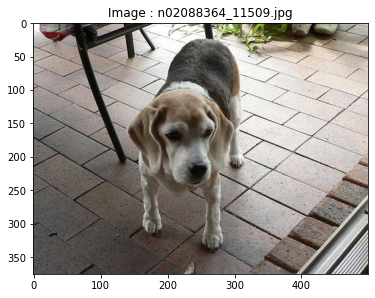

In [114]:
predict_img(680)